# Домашнее задание 4

Это домашнее задание по материалам второго семинаров. Дедлайн по отправке - 23:55 3 марта. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_4

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

## Задача 1

Рассмотрим задачу минимизации:
\begin{equation}
\min_{x \in \triangle_d} f(x) = \frac{1}{2}x^T A x,
\end{equation}
где в качестве матрицы $A$ - случайная матрица (уже умеем генерировать) с $L =1000$, $\mu = 1$, а $\triangle_d$ - вероятностный симплекс:
$$
\triangle_d = \{x ~|~ x_i \geq 0, \sum_{i=1}^d x_i = 1\}.
$$

__(а)__ Для такой задачи напишите итерацию зеркального спуска с дивергенцией Брегмана, порожденной энтропийной функцией. Найдите выражение для итерации метода в явном виде (без подсчетов $\arg\min$).

Зеркальный спуск:
$$
x_{k+1} = \argmin_{x \in \triangle_{d}} \left\{ \langle \nabla f(x_k), x \rangle + \frac{1}{h_k}V(x; x_k) \right\}
$$
Дивергенция Брегмана:
$$
V(x; x_k) = \sum\limits_{i=1}^n x_i \log \frac{x_i}{x_{k, i}}
$$

В нашем случае получается:

$$
x_{k+1} = \argmin_{x \in \triangle_{d}} \left\{ \langle Ax_k, x \rangle + \frac{1}{h} \sum\limits_{i=1}^n x_i \log \frac{x_i}{x_{k, i}} \right\}
$$

Рассмотрим задачу:
$$
 \langle Ax_k, x \rangle + \frac{1}{h} \sum\limits_{i=1}^d x_i \log \frac{x_i}{x_{k, i}} \rightarrow \min_{x \in \triangle_d}
$$

$$
L(x, \lambda) = \langle Ax_k, x \rangle + \frac{1}{h} \sum\limits_{i=1}^d x_i \log \frac{x_i}{x_{k, i}} + \lambda \cdot x 
$$

$$
\nabla_x L_i = A^ix_k + \frac{1}{h} (\log \frac{x_i}{x_{k, i}}) + \lambda = 0
$$
И потом по компонентно получаем

$$
x_i = \frac{x_{i_, k} \cdot exp(-hA^ix_k)}{\sum\limits_{j=1}^d x_{j, k}exp(-h A^j x_k)}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as la

In [85]:
#@title Генерация матрицы
#ответ
def generate_matrix(d, mu, L):
    """
    Функция генерации симметричной квадратной матрицы(d, d),
    с минимальным собственным числом mu, и нормой матрицы L.

    Inputs:
    - d     : размер матрицы 
    - mu    : минимальное собственное число в матрице
    - L     : норма матрицы    
    
    Returns:
    Сгенерированную матрицу.
    """
    tmp = np.random.rand(d, d)  # генерим случайную матрицу
    tmp = tmp + tmp.T           # делаем её симметричной
    u, s, vh = la.svd(tmp)      # раскладываем по svd
    
    s = s - np.amin(s) + mu     # вычитаем минимальный элемент и прибавляем желаемое значение mu
    s[0] = L

    D = np.diag(s)
    A = u.T @ D @ u

    return A

def func_draw_error_time(step, model):
    
    _, ax = plt.subplots(1, 2, figsize=(21, 7))
    y = np.array(model.get_errors())
    x = np.linspace(step, step * len(y), len(y))

    ax[0].set_title("Логарифм ошибки от номера итерации ($error = || \\nabla f(w) ||$)")
    ax[0].plot(x, np.log(y))

    ax[0].set_xlabel("Номер итерации")
    ax[0].set_ylabel("Логарифм ошибки")

    x = np.array(model.get_time())

    ax[1].set_title("Логарифм ошибки от времени ($error = || \\nabla f(w) ||$)")
    ax[1].plot(x, np.log(y))

    ax[1].set_xlabel("Время, с")
    ax[1].set_ylabel("Логарифм ошибки")

In [86]:
def gradient_mirror(A, x, learning_rate):
    tmp = np.exp(-learning_rate *A @ x)
    x_new = x * tmp /(x*tmp).sum()
    return x_new

__(б)__ Реализуйте метод зеркального спуска из пункта (а). Постройте для него график сходимости по времени и по итерациям. В качестве критерия сходимости используйте:
$$
\text{gap}(x^k) = \max_{y \in \triangle_d} \langle \nabla f(x^k), x^k - y \rangle,
$$
или усредненную версию $\frac{1}{k} \sum_{i=1}^k \text{gap}(x^i)$. Найдите выражение в явном виде для подсчета $\text{gap}(x^k)$.

$$
\max_{y \in \triangle_d} \langle \nabla f(x^k), x^k - y \rangle = \langle \nabla f(x^k), x^k \rangle + \max_{y \in \triangle_d} \langle \nabla f(x^k), -y \rangle = \langle \nabla f(x^k), x^k \rangle - \min_{y \in \triangle_d} \langle \nabla f(x^k), y \rangle
$$

Задача решается поиском минимальной координаты в векторе $\nabla f(x^k)$, все остальные координаты y зануляются, а на этом месте ставится единица.

In [92]:
from importlib import reload
import HW_4
reload(HW_4)
from HW_4 import MyMirrorRegression

In [93]:
d = 100
mu = 1
L = 1000
A = generate_matrix(d, mu, L)
step = 1000
iter = 1000
eps = 10e-6

In [94]:
model = MyMirrorRegression()
model.fit(A, eps=eps, iter=iter, step=step)

0.9999999999999999


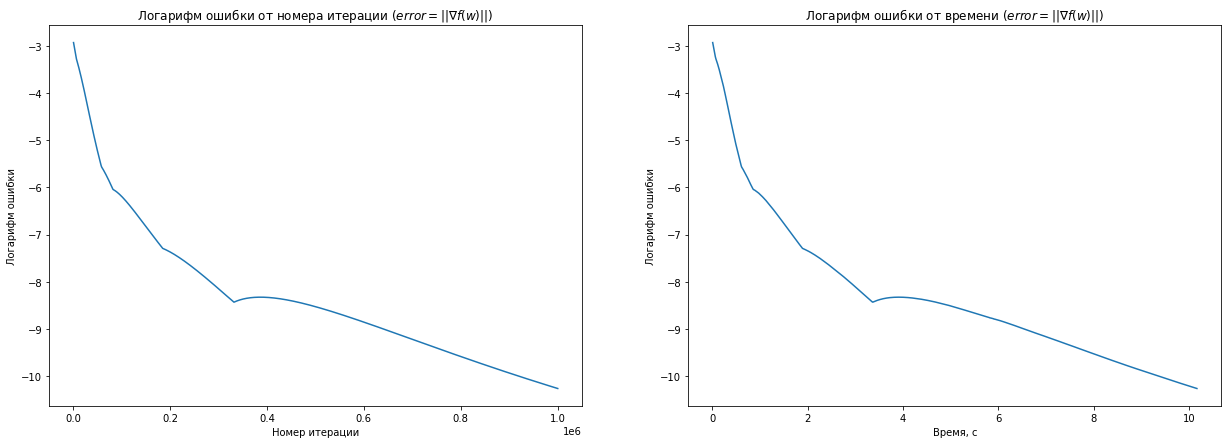

In [95]:
print(model.get_weights().sum())
func_draw_error_time(step, model)

__(в)__ Для этой же задачи напишите итерацию метода Франка-Вульфа. Реализуйте этот метод. Постройте для него график сходимости по времени и по итерациям. Добавьте эти графики к графикам для зеркального спуска. Сделайте вывод.

In [96]:
model_w = MyMirrorRegression()
model_w.fit(A, eps=eps, iter=iter, step=step, wolf=True)

0.9999999999999986


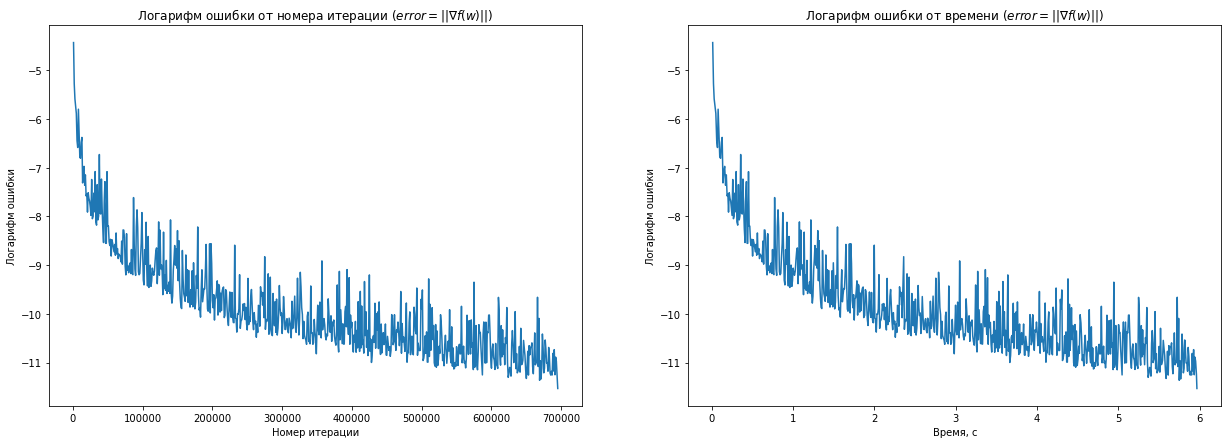

In [97]:
print(model_w.get_weights().sum())
func_draw_error_time(step, model_w)

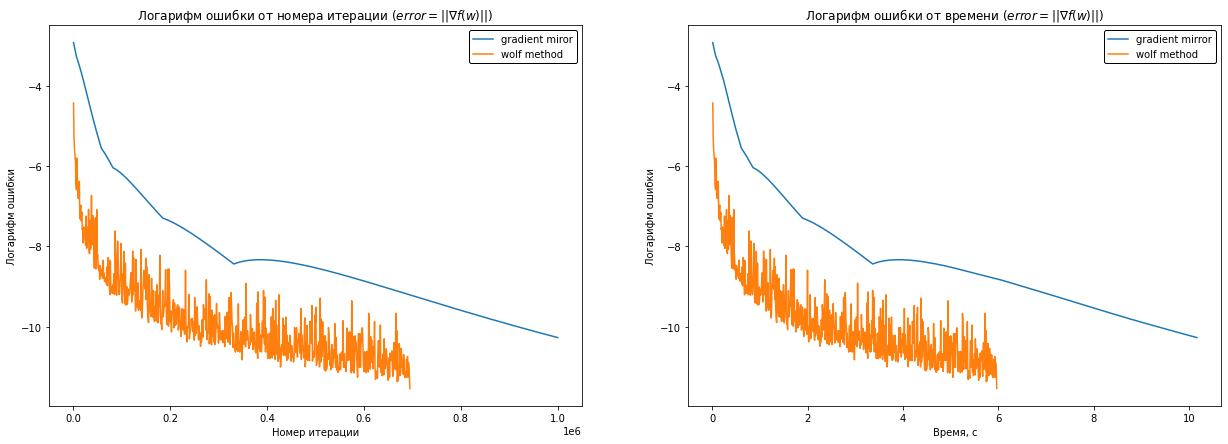

In [98]:
_, ax = plt.subplots(1, 2, figsize=(21, 7))


ax[0].set_title("Логарифм ошибки от номера итерации ($error = || \\nabla f(w) ||$)")
ax[1].set_title("Логарифм ошибки от времени ($error = || \\nabla f(w) ||$)")

y = np.array(model.get_errors())
x = np.linspace(step, step * len(y), len(y))
ax[0].plot(x, np.log(y), label='gradient miror')
ax[1].plot(np.array(model.get_time()), np.log(y), label='gradient mirror')

y = np.array(model_w.get_errors())
x = np.linspace(step, step * len(y), len(y))
ax[0].plot(x, np.log(y), label='wolf method')
ax[1].plot(np.array(model_w.get_time()), np.log(y), label='wolf method')


ax[0].set_xlabel("Номер итерации")
ax[0].set_ylabel("Логарифм ошибки")
ax[1].set_xlabel("Время, с")
ax[1].set_ylabel("Логарифм ошибки")

legend_box = ax[1].legend(framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")

legend_box = ax[0].legend(framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")

__Бонусные пункты__

__(г)__ Реализуйте метод градиентного спуска для нашей задачи. Для этого найдите в Интернете алгоритм евклидовой проекции на вероятностный симплекс. Постройте для градиентного спуска с евклидовой проекцией график сходимости по времени и по итерациям. Добавьте эти графики к графикам для зеркального спуска и метода Франка-Вульфа. Сделайте вывод.

In [11]:
#ответ

__(д)__ В [работе](https://sci-hub.ru/https://doi.org/10.1137/140992382) представлена ускоренная версия метода Франка-Вульфа (Алгоритм 2 для сильно выпуклой задачи). Он лучше с точки зрения теоретической сходимости по числу вызовов градиента. Реализуйте Алгоритм 2 для нашей задачи. Постройте график сходимости по времени и по количеству подсчетов $\nabla f$ (для предыдущих методов это было эквивалетно итерациям). Добавьте эти графики к графикам для остальных методов которые были получены выше. Сделайте вывод.

In [12]:
#ответ